In [49]:
import argparse
from hydra import compose, initialize
import sys
sys.path.append('..')
from meg_ssl.dataclass import parse_dataset
from meg_ssl.models import get_model_and_trainer
from meg_ssl.utils import set_seed
from omegaconf import OmegaConf
import wandb
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/home/yainoue/meg2image/codes/MEG-decoding')
import h5py
from meg_decoding.matlab_utils.load_meg import roi
import mne

In [4]:
# get dataset
def get_dataset(cfg:OmegaConf):
    dataset_names:dict = cfg.dataset_name
    # import pdb; pdb.set_trace()
    dataset_yamls:dict = cfg.dataset_yaml
    num_trial_limit:dict = cfg.total_limit
    preproc_config:OmegaConf = cfg.preprocess
    h5_root:str = cfg.h5_root
    image_preprocs:list = []
    meg_preprocs:list = []
    only_meg:bool = True
    on_memory:bool = False
    dataset_dict:dict = parse_dataset(dataset_names, dataset_yamls, preproc_config, num_trial_limit, 
                                      h5_root, image_preprocs, meg_preprocs, only_meg, on_memory)
    
    return dataset_dict['train'], dataset_dict['val']
    

In [13]:
# load config
config_name = 'test_config'
with initialize(config_path='../meg_ssl/ssl_configs/'):
    main_cfg = compose(config_name)

train_dataset, val_dataset = get_dataset(main_cfg)

/tmp/ipykernel_212157/2998827235.py:3: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path='../meg_ssl/ssl_configs/'):


session_ids 1~3 1 3
=================GOD=================
sbj_1-session_1~3
dataset_info_list:  [{'meg_path': '/work/project/MEG_GOD/GOD_dataset/VideoWatching/preprocess_MEG/sbj01/ID01_HerosVol1-1_id1_MEG_DATAPixx_part2.mat', 'movie_path': '/storage/dataset/MEG/internal/AnnotatedMovie_v1/tmp/stim_video/ID01_HerosVol1-1_id1_MEG_DATAPixx_part2.mp4', 'movie_trigger_path': '/home/yainoue/meg2image/codes/MEG-decoding/data/movies/video1-part2_onset_triggers.csv', 'meg_trigger_path': '/home/yainoue/meg2image/codes/matlab_codes/triggers/sbj01/onset_trigger_video_1-part_2.csv', 'sbj_name': 'sbj01', 'h5_file_name': '../../../dataset/ssl_dataset/test/drama/sbj01_ID01_HerosVol1-1_id1_MEG_DATAPixx_part2.mp4.h5', 'split': 'train', 'movie_crop_pts': [[297, 528], [783, 1392]]}, {'meg_path': '/work/project/MEG_GOD/GOD_dataset/VideoWatching/preprocess_MEG/sbj01/ID01_HerosVol1-1_id1_MEG_DATAPixx_part3.mat', 'movie_path': '/storage/dataset/MEG/internal/AnnotatedMovie_v1/tmp/stim_video/ID01_HerosVol1-1_id1

In [69]:
train_data = train_dataset[100]
val_data = val_dataset[100]

In [70]:
train_data.shape

(22, 48)

In [71]:
val_data.shape

(22, 48)

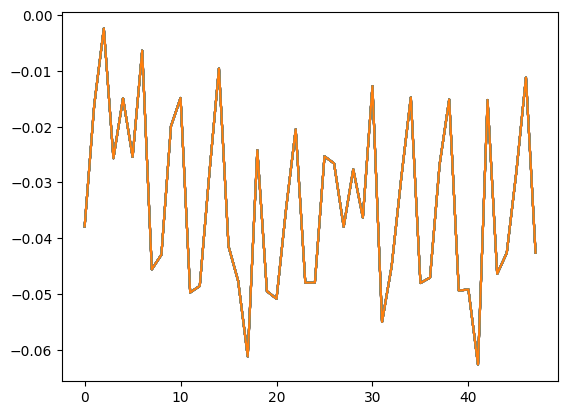

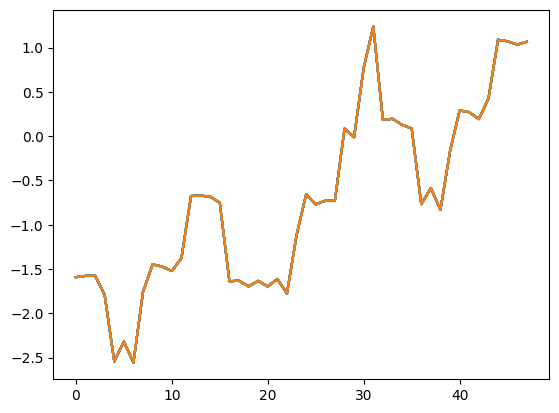

In [72]:
plt.plot(val_data.T)
plt.show()
plt.plot(train_data.T)
plt.show()

In [73]:
train_data

array([[-1.5919113, -1.5779715, -1.5735512, ...,  1.0716866,  1.0337622,
         1.0665318],
       [-1.5919113, -1.5779715, -1.5735512, ...,  1.0716866,  1.0337622,
         1.0665318],
       [-1.5919113, -1.5779715, -1.5735512, ...,  1.0716866,  1.0337622,
         1.0665318],
       ...,
       [-1.5919113, -1.5779715, -1.5735512, ...,  1.0716866,  1.0337622,
         1.0665318],
       [-1.5919113, -1.5779715, -1.5735512, ...,  1.0716866,  1.0337622,
         1.0665318],
       [-1.5919113, -1.5779715, -1.5735512, ...,  1.0716866,  1.0337622,
         1.0665318]], dtype=float32)

In [74]:
with h5py.File(train_dataset.datasets[0].h5_file_name, "r") as h5:
    ROI_MEG_Data = h5['ROI_MEG_Data'][:,:] # ndim =2

In [75]:
ROI_MEG_Data.shape

(22, 209040)

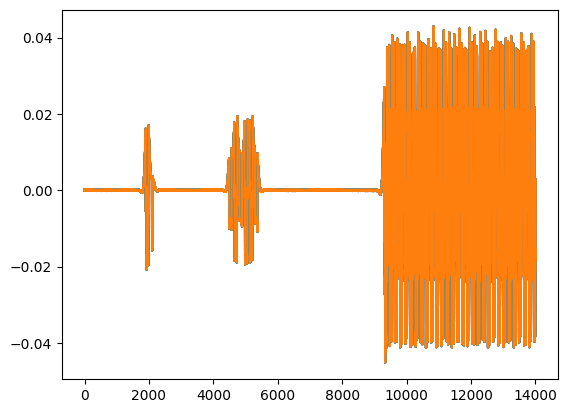

In [76]:
plt.plot(ROI_MEG_Data[:,1000:15000].T)
plt.show()

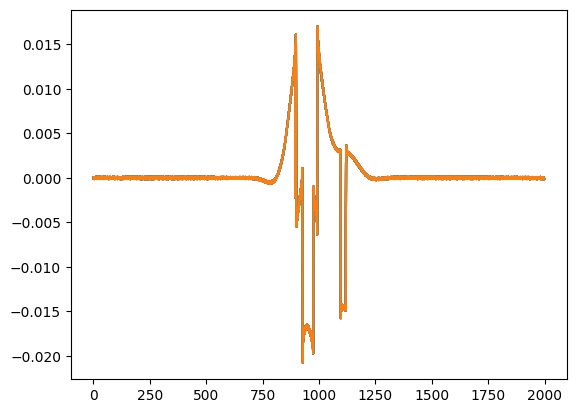

In [77]:
plt.plot(ROI_MEG_Data[:,2000:4000].T)
plt.show()

In [78]:
roi_channels:np.ndarray = roi(train_dataset.datasets[0].dataset_config)

ROI:  ['occipital/left', 'occipital/right']
channel (-1 is done because matlab starts from 1):  [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
num channels:  22


In [79]:
MEG_Data:np.ndarray = train_dataset.datasets[0].get_meg_matlab_data( train_dataset.datasets[0].meg_path)

In [80]:
MEG_Data.shape
ROI_MEG_Data = MEG_Data[roi_channels,:]

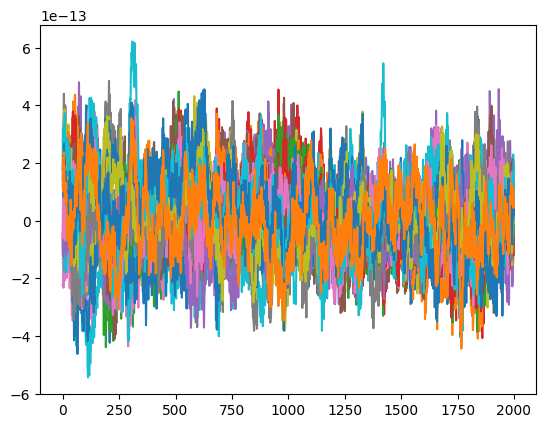

In [81]:
plt.plot(MEG_Data[roi_channels, 2000:4000].T)
plt.show()

In [82]:
ROI_MEG_Data_filtered = mne.filter.filter_data(ROI_MEG_Data, sfreq=1000, l_freq=2, h_freq=120)

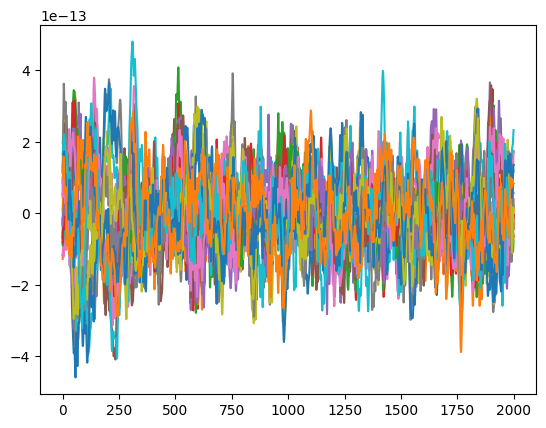

In [83]:
plt.plot(ROI_MEG_Data_filtered[:, 2000:4000].T)
plt.show()

In [84]:
ROI_MEG_Data_filtered = mne.filter.resample(ROI_MEG_Data_filtered, down=train_dataset.datasets[0].meg_fs / train_dataset.datasets[0].preproc_config.brain_resample_rate)

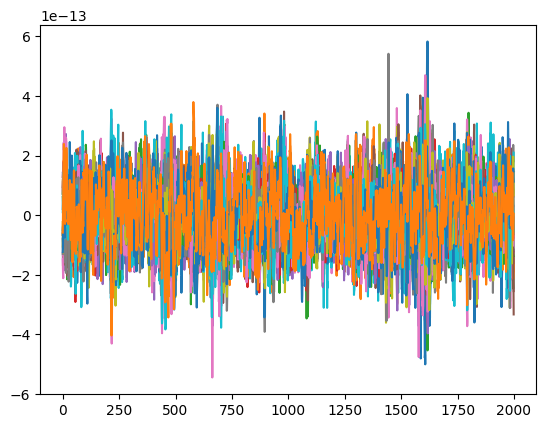

In [85]:
plt.plot(ROI_MEG_Data_filtered[:, 2000:4000].T)
plt.show()

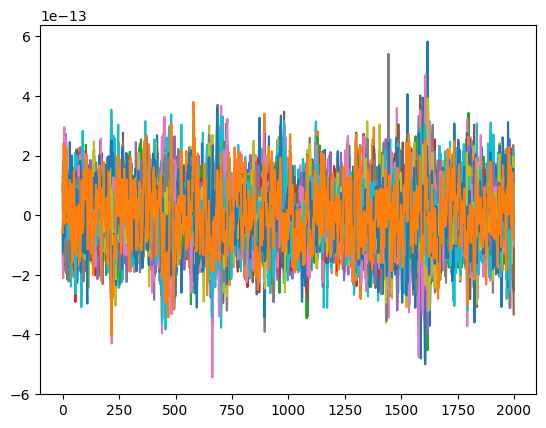

In [86]:
ROI_MEG_Data_filtered = ROI_MEG_Data_filtered.astype(np.float32)
plt.plot(ROI_MEG_Data_filtered[:, 2000:4000].T)
plt.show()

In [87]:
with h5py.File('tmp_meg.h5', "w") as h5:
    h5.create_dataset("ROI_MEG_Data", data=ROI_MEG_Data_filtered)
    ROI_MEG_Data_filtered = 0

In [88]:
with h5py.File('tmp_meg.h5', "r") as h5:
    ROI_MEG_Data_filtered = h5['ROI_MEG_Data'][:,:] # ndim =2

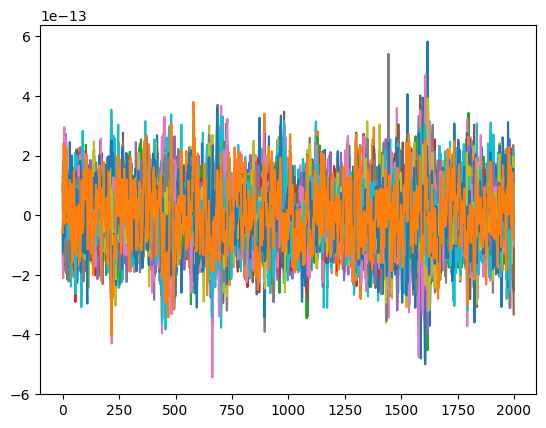

In [89]:
ROI_MEG_Data_filtered = ROI_MEG_Data_filtered.astype(np.float32)
plt.plot(ROI_MEG_Data_filtered[:, 2000:4000].T)
plt.show()

In [62]:
with h5py.File(train_dataset.datasets[0].h5_file_name, "r") as h5:
    ROI_MEG_Data = h5['ROI_MEG_Data'][:,:] # ndim =2

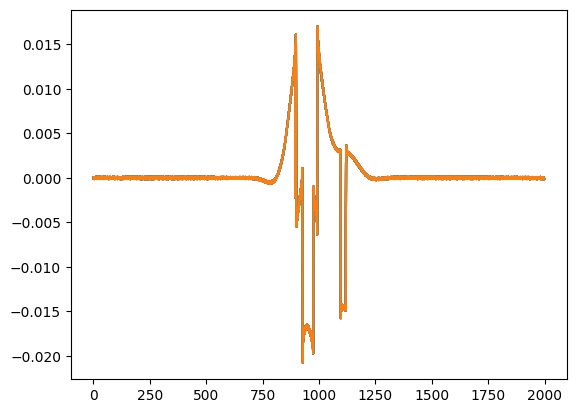

In [64]:
plt.plot(ROI_MEG_Data[:, 2000:4000].T)
plt.show()